### global和hybrid的聚类结果存在互补的情况

In [ ]:
import torch
import os
import numpy as np
from sklearn import manifold
import random
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import pair_confusion_matrix
import sys
from FINCH_context_SpCL_plus import label_generator_FINCH_context_SpCL_Plus
from mmcv import Config

path = "/home/linhuadong/DNFNet/jobs/prw_SC_STC_0p001"
features = torch.load(os.path.join(path, "saved_file", "features.pth"))
part_features = features = torch.load(os.path.join(path, "saved_file", "part_features.pth"))
person_ids = torch.load(os.path.join(path, "saved_file", "person_ids.pth"))
img_ids = torch.load(os.path.join(path, "saved_file", "img_ids.pth"))
cfg = Config.fromfile(os.path.join(path, "work_dirs/prw/", "prw.py"))

cfg.PSEUDO_LABELS.part_feat.use_part_feat = True
hybrid_labels, centers, num_classes, indep_thres = label_generator_FINCH_context_SpCL_Plus(cfg, features, cuda=True, indep_thres=None, all_inds=img_ids)
cfg.PSEUDO_LABELS.part_feat.use_part_feat = False
global_labels, centers, num_classes, indep_thres = label_generator_FINCH_context_SpCL_Plus(cfg, features, cuda=True, indep_thres=None, all_inds=img_ids)


In [65]:
pseudo_labels = hybrid_labels
num_person_ids = len(set(person_ids.numpy()))
all_instance = len(person_ids)
unlabeled_instance = len(torch.nonzero(person_ids == torch.tensor(-1)))
labelded_instance = all_instance - unlabeled_instance

def get_selected_idx(num_person_ids, person_ids, pseudo_labels):
    idxs = [266, 263, 203, 262]#, 162]# 66, 162, 197, 87, 47]   # 72
    select_idx = []
    for idx in idxs:
        select_idx += torch.nonzero(person_ids == torch.tensor(idx))
    return select_idx

select_idx = get_selected_idx(num_person_ids, person_ids, pseudo_labels)
select_features = features[select_idx]
select_person_ids = person_ids[select_idx]
select_pseudo_labels = pseudo_labels[select_idx]

X = select_features

def id_mapping(ids):
    # 将person id映射到从0开始编码
    unique_ids = set(np.array(ids))
    mapping = {}
    for i, value in enumerate(list(unique_ids)):
        mapping[value] = i
    Y = np.array(ids).copy()
    for i in range(Y.shape[0]):
        Y[i] = mapping[Y[i]]
    return Y

Y = id_mapping(select_person_ids)
select_pseudo_labels = id_mapping(select_pseudo_labels)
select_person_ids = select_person_ids.tolist()
select_pseudo_labels = select_pseudo_labels.tolist()

/home/linhuadong/miniconda3/envs/mmdet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/linhuadong/miniconda3/envs/mmdet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


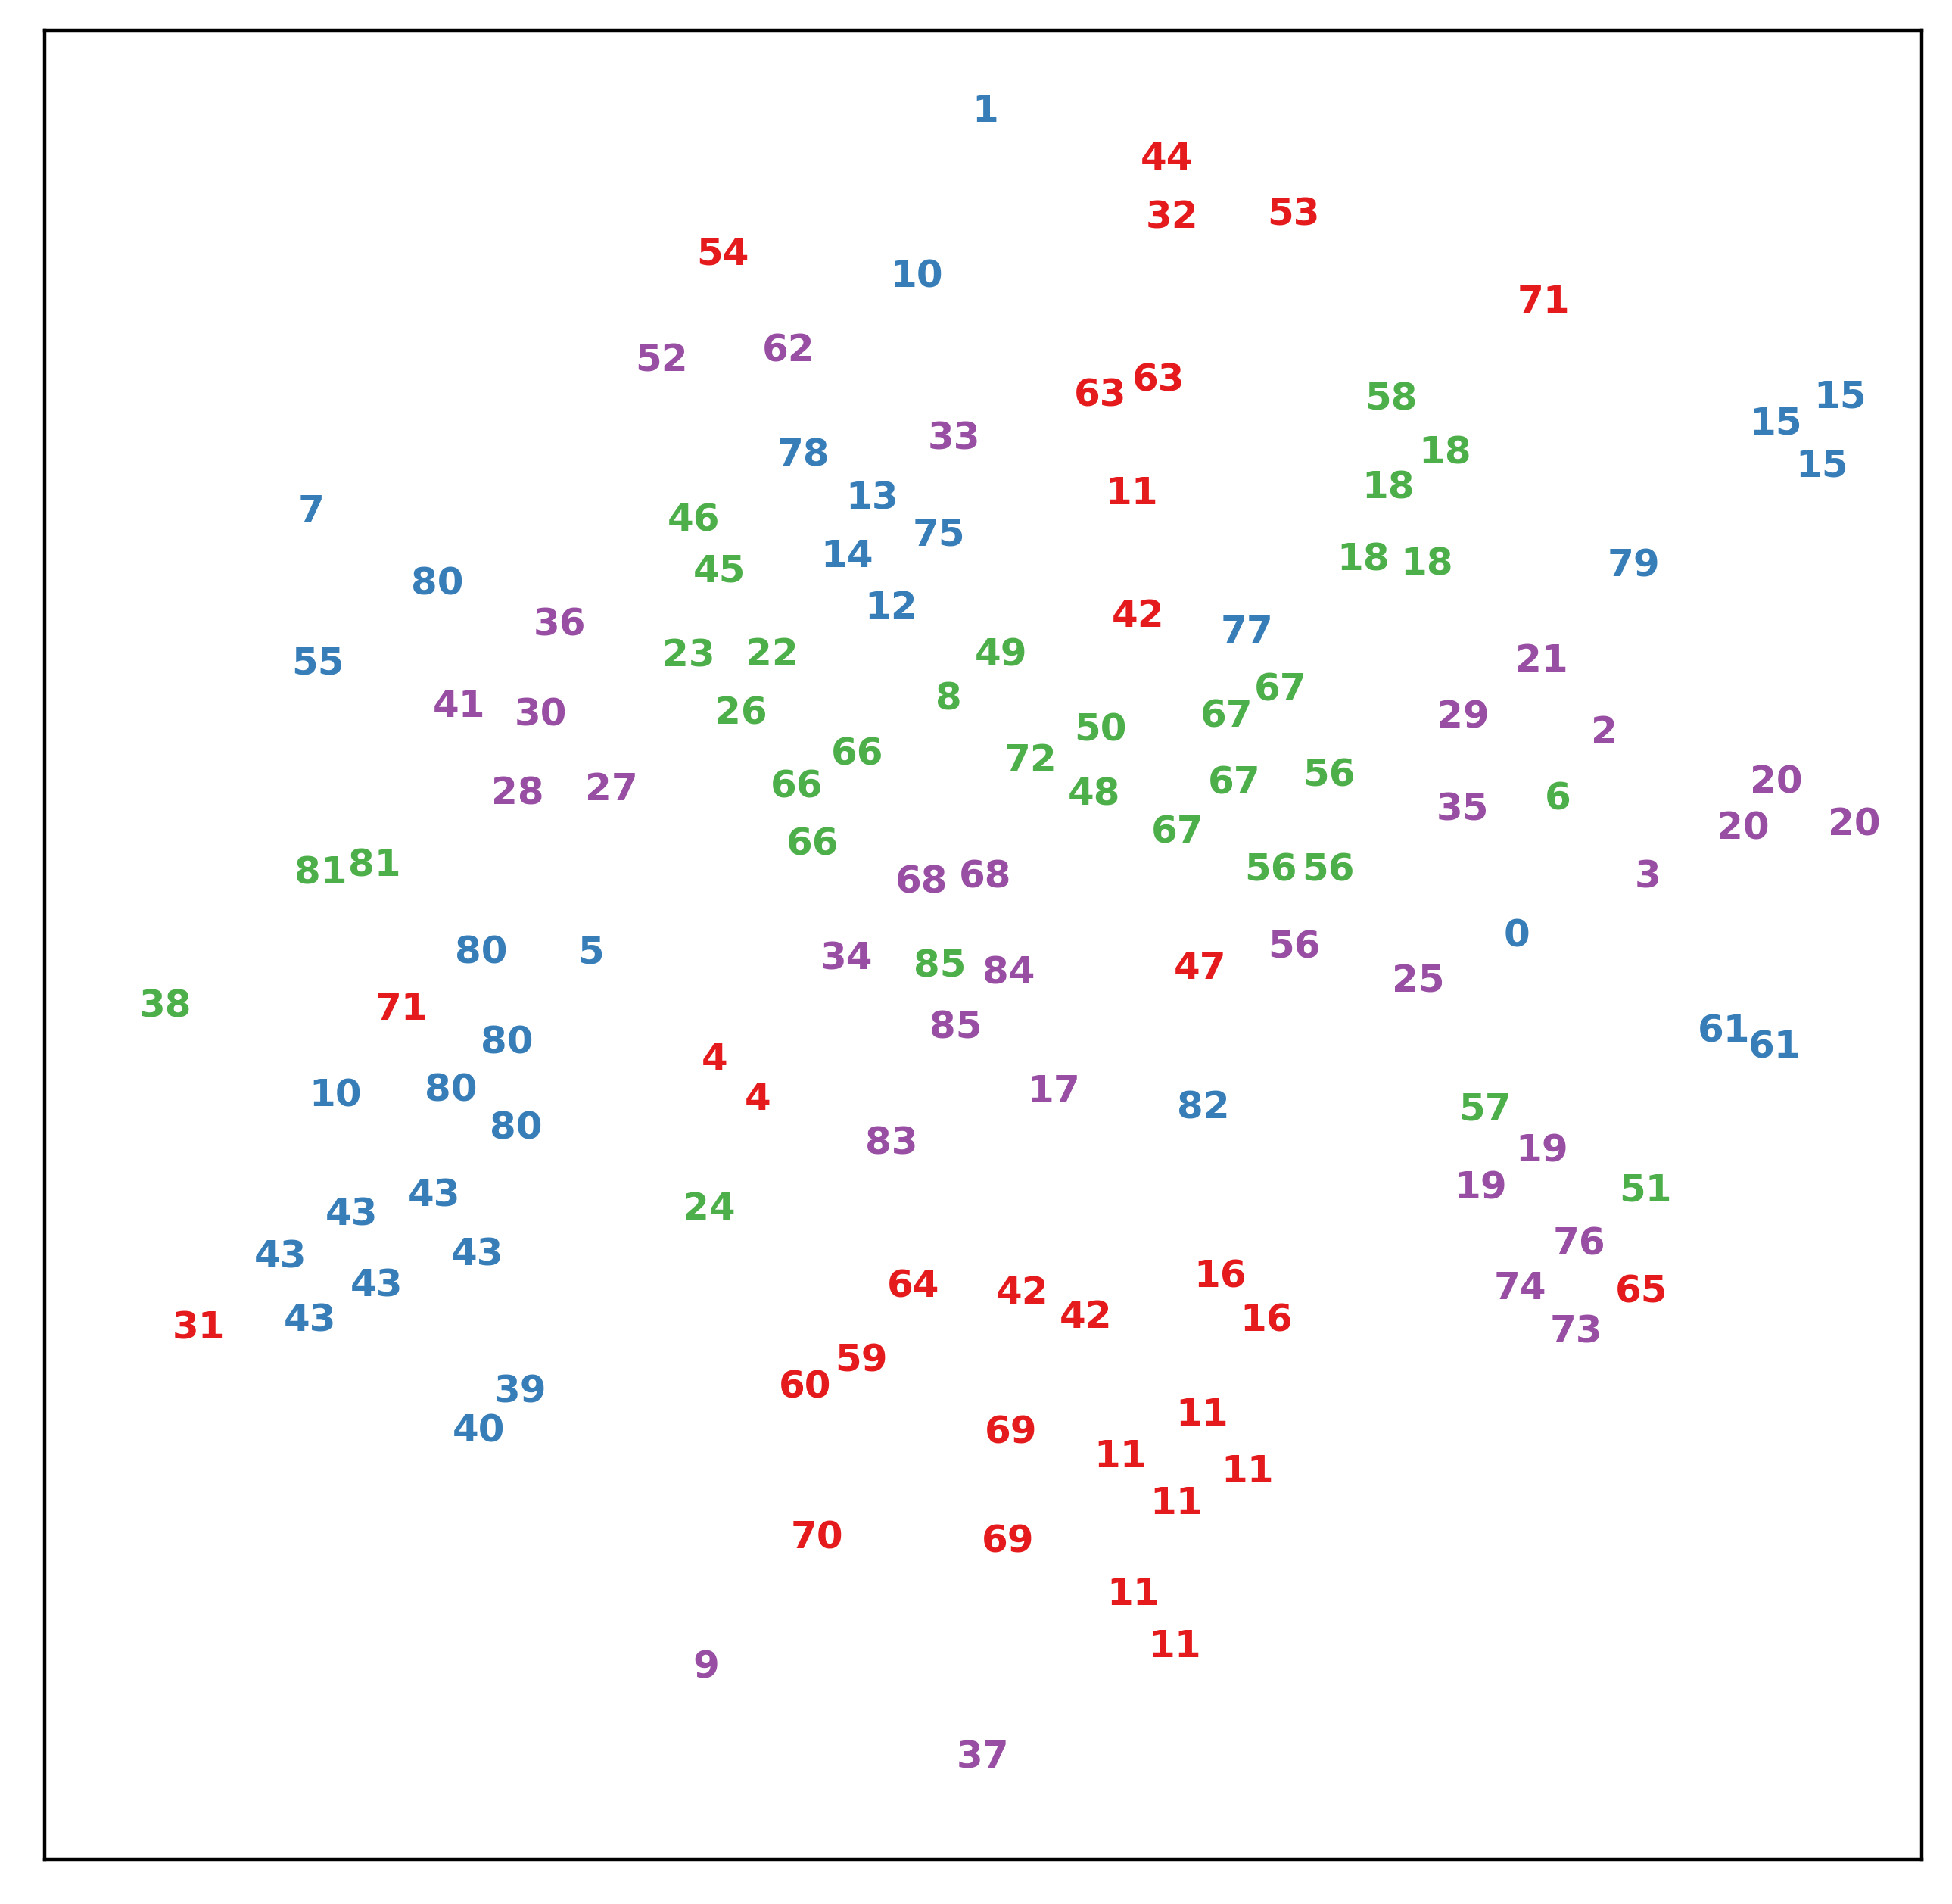

In [66]:
def visualize(X, y):
    '嵌入空间可视化'''
    x_min, x_max = X.min(0), X.max(0)
    X_norm = 0.05 + (X - x_min) / (x_max - x_min) * (0.95 - 0.05)  # 归一化
    plt.figure(figsize=(8, 8), dpi=400)
    ax = plt.gca()
    # 颜色表示GT聚类,不同形状表示预测的聚类
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(select_pseudo_labels[i]), color=plt.cm.Set1(y[i]), fontdict={'weight': 'bold', 'size': 9})
        # plt.text(X_norm[i, 0], X_norm[i, 1], '●', color=plt.cm.Set1(y[i]), fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    # plt.savefig("./tSNE.jpg", bbox_inches='tight', pad_inches=0)
    # plt.savefig('./FINCH_context.eps', dpi=100, format='eps', bbox_inches='tight', pad_inches=0)
    plt.show()
X_tsne = manifold.TSNE(n_components=2, perplexity=30, learning_rate=500, init='pca', random_state=501, n_iter=600, verbose=0, metric='cosine').fit_transform(X)
visualize(X_tsne, Y)